### Objetivos:
- Aplicar Machine Learning a um Case de Saúde
- Demonstrar o uso de Ensembles

In [1]:
# !pip install -q -U watermark

In [2]:
import pandas as pd
import numpy as np
import itertools

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_recall_curve
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from imblearn.over_sampling import BorderlineSMOTE

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
%reload_ext watermark
%watermark -a "Case 08 - Ensembles na área da Saúde"
%watermark --iversions

Author: Case 08 - Ensembles na área da Saúde

imblearn   : 0.12.0
xgboost    : 2.0.3
seaborn    : 0.13.2
pandas     : 2.2.3
lightgbm   : 4.3.0
statsmodels: 0.14.1
numpy      : 1.26.4
sklearn    : 1.4.2
matplotlib : 3.8.4
keras      : 3.9.2



### Dicionário de Dados: Pima Indians Diabetes Database

| Coluna                      | Descrição                                                                                 |
|-----------------------------|-------------------------------------------------------------------------------------------|
| `Pregnancies`                | Número de gestações da paciente.                                                           |
| `Glucose`                    | Concentração de glicose plasmática em jejum (mg/dL).                                        |
| `BloodPressure`              | Pressão arterial diastólica (mm Hg).                                                       |
| `SkinThickness`              | Espessura da dobra cutânea tricipital (mm), usada para medir a quantidade de gordura corporal. |
| `Insulin`                    | Concentração de insulina sérica (mu U/mL).                                                 |
| `BMI`                        | Índice de Massa Corporal (IMC), calculado como peso (kg) / (altura em metros)^2.            |
| `DiabetesPedigreeFunction`   | Função de pedigree de diabetes, indicando a probabilidade de diabetes com base no histórico familiar. |
| `Age`                        | Idade da paciente (anos).                                                                  |
| `Outcome`                    | Diagnóstico de diabetes: 1 se diagnosticado com diabetes, 0 se não diagnosticado.           |


- Link do Dataset: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database
- Artigo de Referência: https://www.sciencedirect.com/science/article/pii/S240584402400567X

In [4]:
df = pd.read_csv('./dataset/diabetes.csv')
display(df.head())
print(df.shape)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


(768, 9)


<Axes: xlabel='Outcome', ylabel='count'>

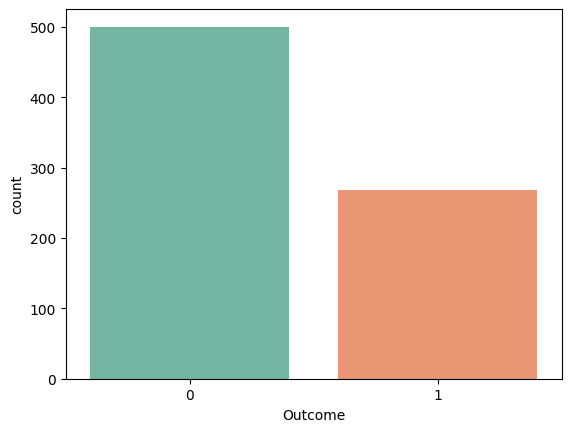

In [5]:
sns.countplot(x='Outcome', data=df, palette='Set2')

In [6]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

smote = BorderlineSMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

df = pd.concat([pd.DataFrame(X_res, columns=X.columns), pd.Series(y_res, name='Outcome')], axis=1)

Borderline-SMOTE: https://sci2s.ugr.es/keel/keel-dataset/pdfs/2005-Han-LNCS.pdf

<Axes: xlabel='Outcome', ylabel='count'>

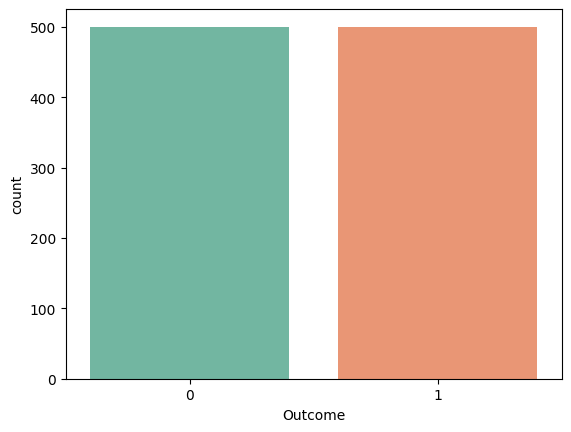

In [7]:
sns.countplot(x='Outcome', data=df, palette='Set2')

In [8]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,3.983000,121.779000,70.145000,21.134000,79.672000,32.630612,0.494330,33.729000,0.50000
std,3.330436,29.623297,17.769348,16.115948,110.606257,7.402760,0.324241,11.340289,0.50025
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.00000
25%,1.000000,102.000000,64.000000,0.000000,0.000000,28.307121,0.256000,25.000000,0.00000
50%,3.000000,120.000000,72.000000,24.500000,23.500000,32.800000,0.408500,30.000000,0.50000
75%,6.000000,139.000000,80.000000,33.000000,130.000000,36.800000,0.664691,41.000000,1.00000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.00000


In [9]:
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

#### Observando a quantidade de valores nulos não veio nenhum dado faltante, no entanto, foram identificadas variáveis preenchidas com zero quando na verdade não fazem sentido para questões biológicas, então serão tratadas como nulas

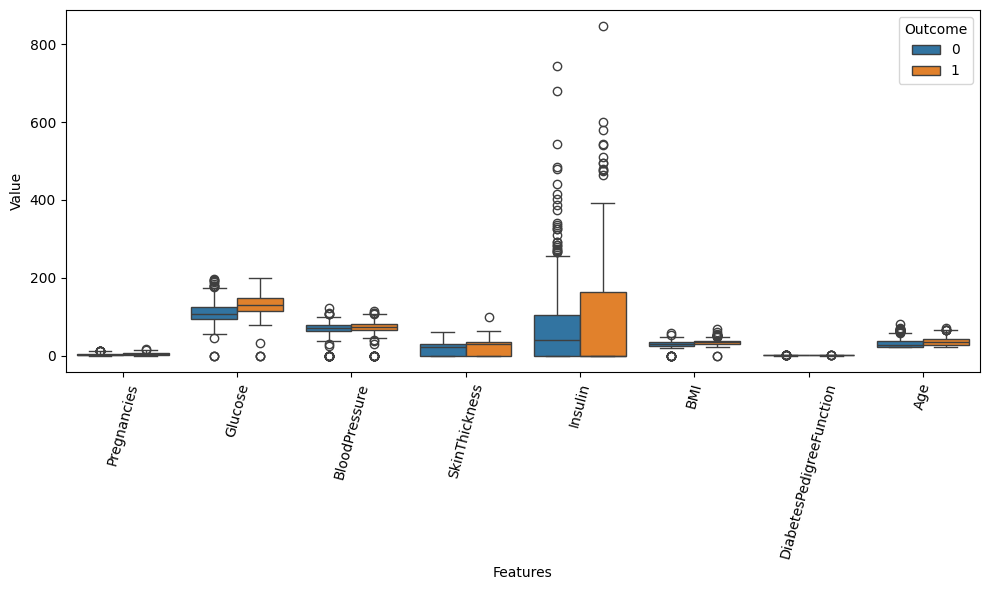

In [10]:
data_melted = pd.melt(df, id_vars='Outcome',
                      var_name='Features',
                      value_name='Value')

plt.figure(figsize=(10, 6))
sns.boxplot(x='Features', y='Value', hue='Outcome', data=data_melted)

plt.xticks(rotation=75)

plt.tight_layout()
plt.show()

In [11]:
cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for col in cols:
    median = df[col].median()
    df[col] = df[col].replace(0, median)  

In [12]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,3.983000,122.499000,72.665000,28.410500,91.234000,32.991412,0.494330,33.729000,0.50000
std,3.330436,28.070803,11.710248,8.792329,102.604727,6.553382,0.324241,11.340289,0.50025
min,0.000000,32.000000,24.000000,5.000000,14.000000,18.200000,0.078000,21.000000,0.00000
25%,1.000000,103.000000,65.000000,24.500000,23.500000,28.500000,0.256000,25.000000,0.00000
50%,3.000000,120.000000,72.000000,24.750000,23.750000,32.800000,0.408500,30.000000,0.50000
75%,6.000000,139.000000,80.000000,33.000000,130.000000,36.800000,0.664691,41.000000,1.00000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.00000


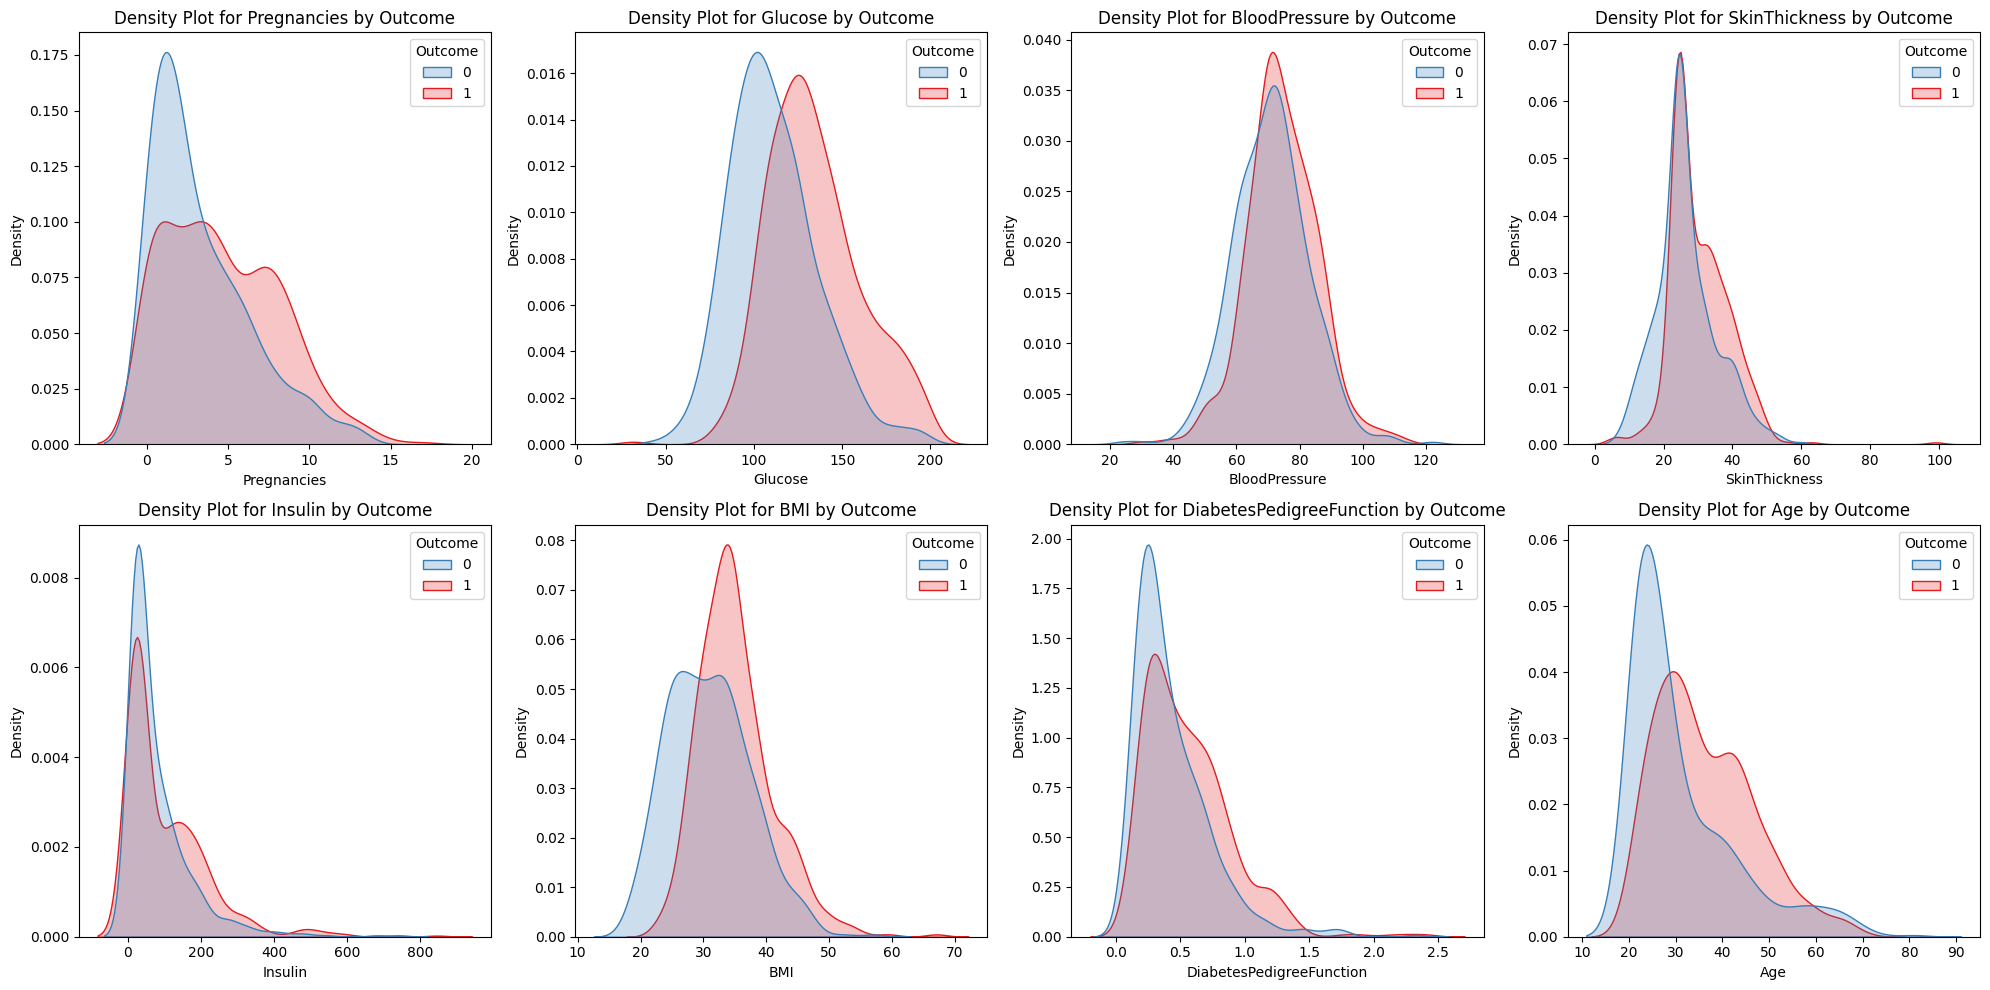

In [13]:
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 
            'BMI', 'DiabetesPedigreeFunction', 'Age']

n_features = len(features)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols
outcome_pallet = sns.color_palette("Set1")

plt.figure(figsize=(20, 5 * n_rows))

for i, feature in enumerate(features):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.kdeplot(data=df, x=feature, hue='Outcome', fill=True, common_norm=False, palette={0: outcome_pallet[1], 1: outcome_pallet[0]})
    plt.title(f'Density Plot for {feature} by Outcome')
    plt.xlabel(feature)
    plt.ylabel('Density')

plt.tight_layout()  
plt.show()

#### Avaliação da separabilidade das classes pelos preditores
- BloodPressure apresenta distribuições sobrepostas, isso pode indicar que não é uma variável muito útil se observada isoladamente para prever se tem a doença ou não.
- Glucose e BMI são variáveis que indicam que maiores valores das distribuições podem são casos com maiores chances de ter diabetes

### Correlograma para avaliar Multicolinearidade

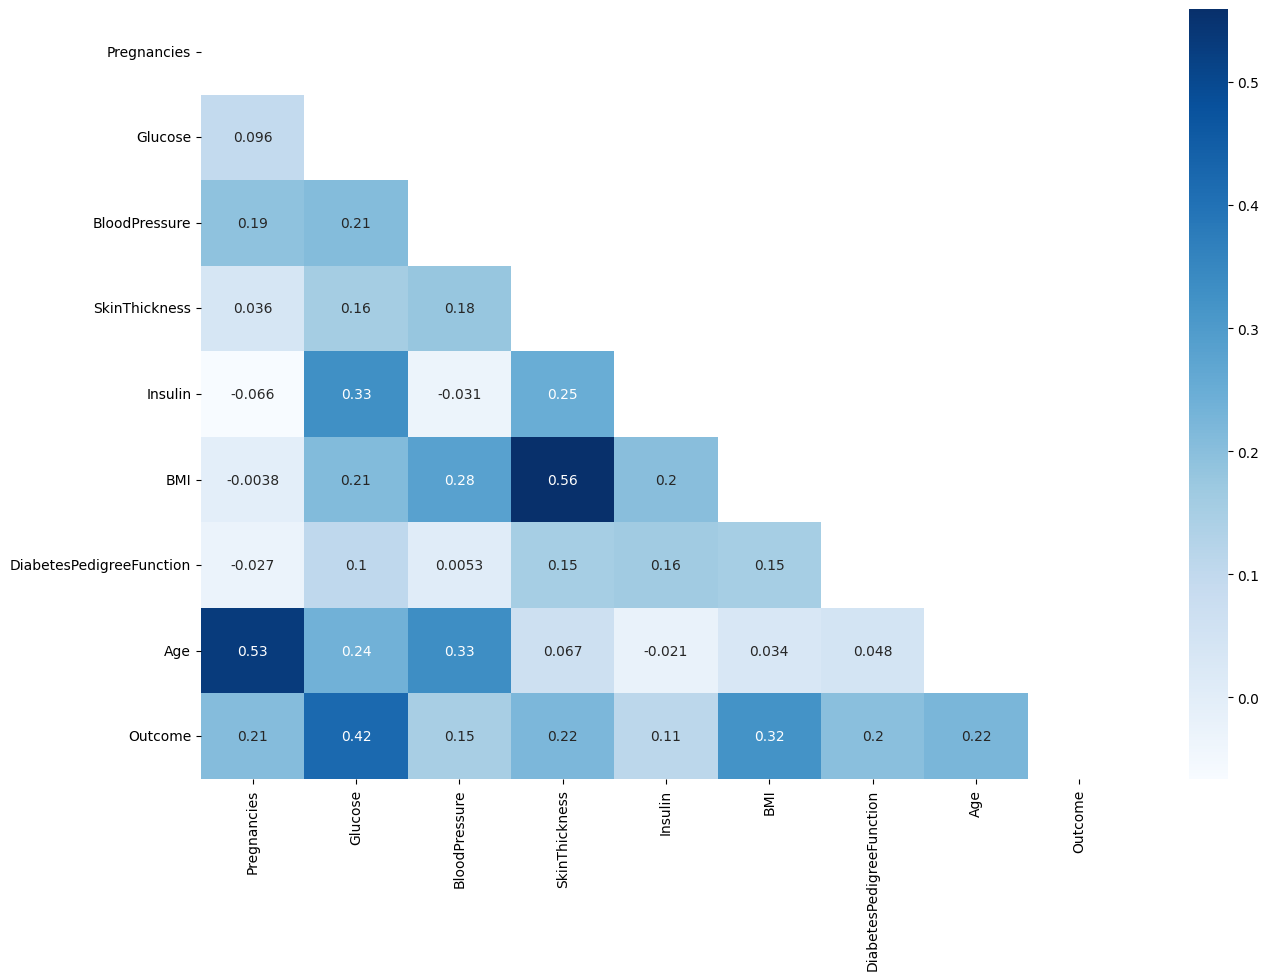

In [14]:
fig, ax = plt.subplots(figsize=(15,10))
corr_matrix = df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix,
            annot=True,
            cmap='Blues',
            mask=mask,
            ax=ax)
plt.show()

### VIF

In [15]:
X = df[features]
X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data.to_markdown(index=False, tablefmt='pipe'))

| Variable                 |      VIF |
|:-------------------------|---------:|
| const                    | 59.6686  |
| Pregnancies              |  1.40446 |
| Glucose                  |  1.25044 |
| BloodPressure            |  1.25834 |
| SkinThickness            |  1.51243 |
| Insulin                  |  1.22614 |
| BMI                      |  1.58499 |
| DiabetesPedigreeFunction |  1.05547 |
| Age                      |  1.57919 |


### Remoção de outliers

In [16]:
def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude

def excluir_outliers(df, nome_coluna):
    qtde_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    linhas_removidas = qtde_linhas - df.shape[0]
    return df, linhas_removidas

def diagrama_caixa(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)

def histograma(coluna):
    plt.figure(figsize=(15, 5))
    sns.distplot(coluna, hist=True)
    
def grafico_barra(coluna):
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())
    ax.set_xlim(limites(coluna))

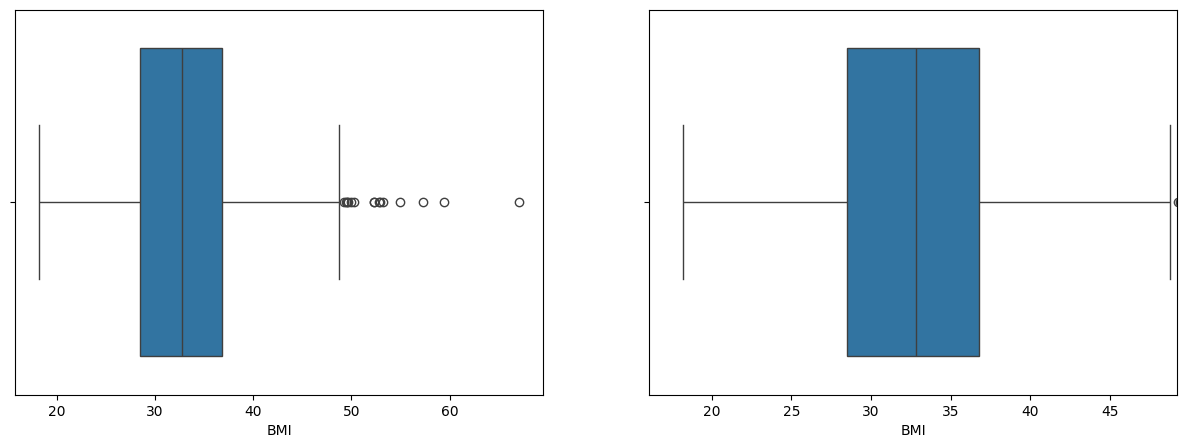

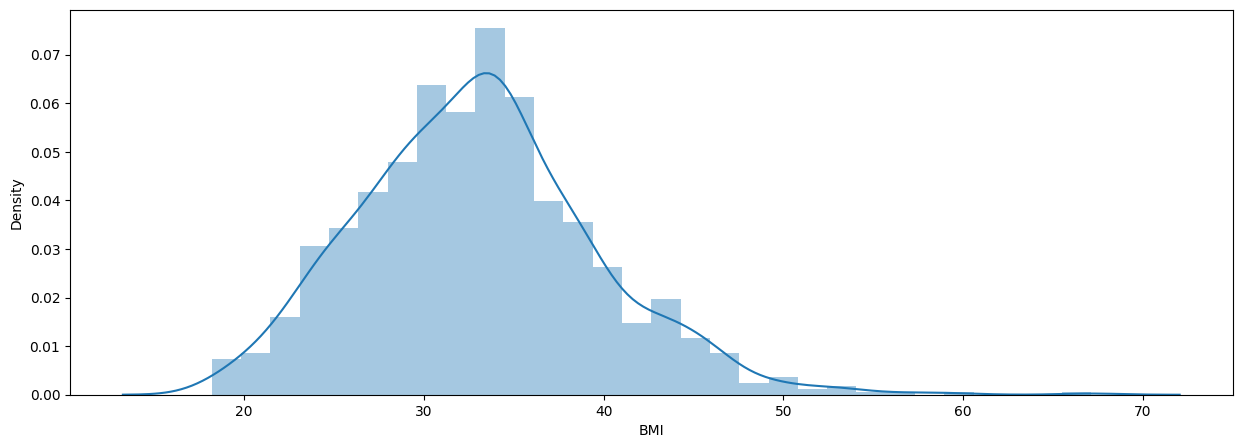

In [17]:
diagrama_caixa(df['BMI'])
histograma(df['BMI'])

In [18]:
df, linhas_removidas = excluir_outliers(df, 'BMI')
print(f'{linhas_removidas} linhas removidas')

15 linhas removidas


(985, 9)


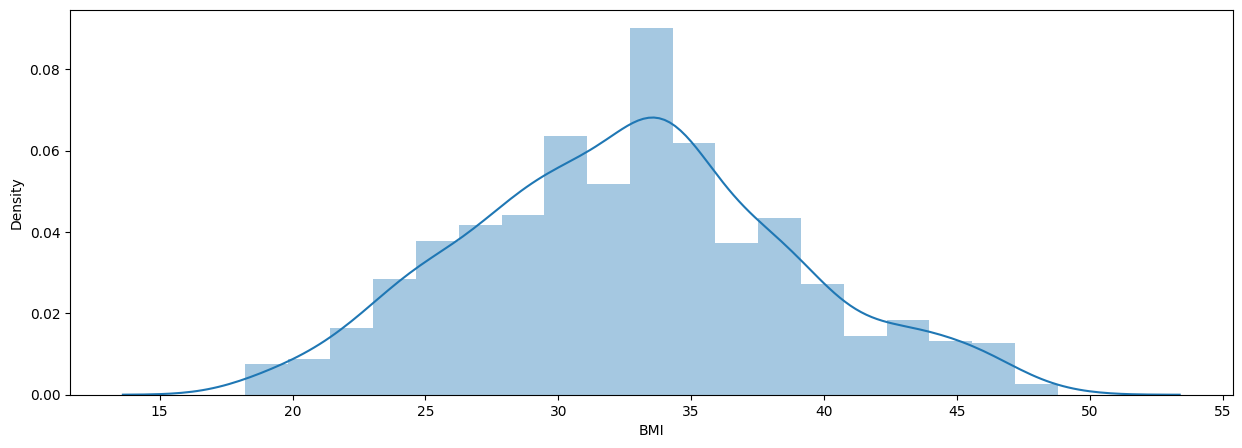

In [19]:
histograma(df['BMI'])
print(df.shape)

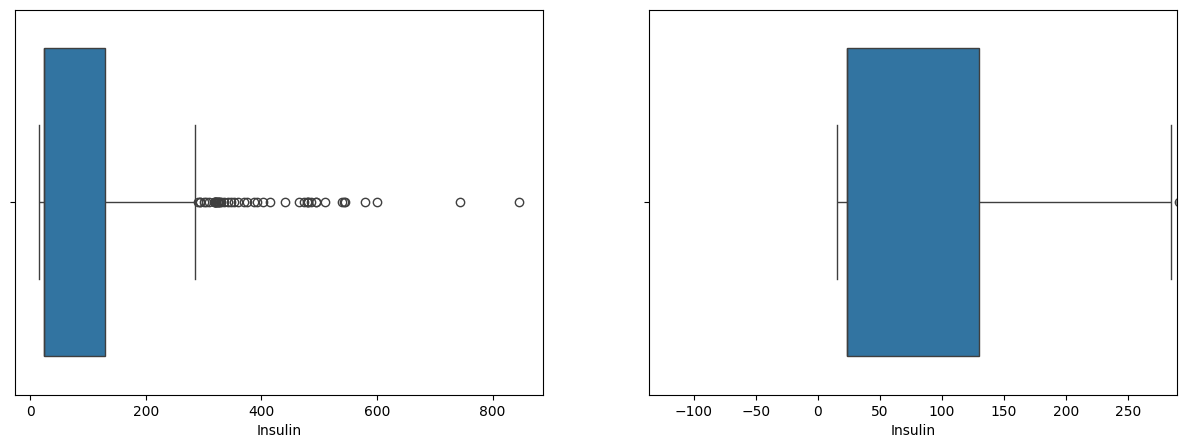

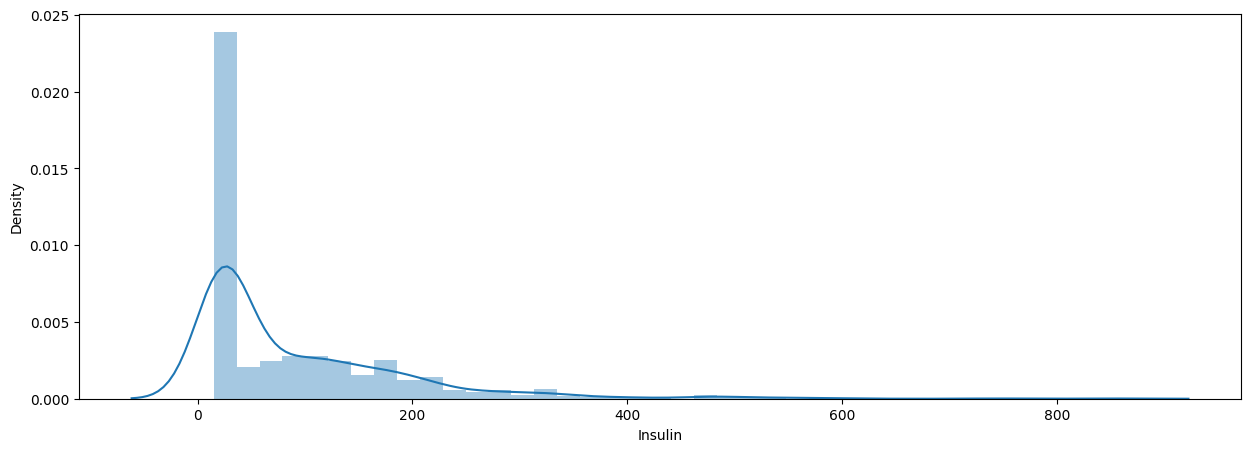

In [20]:
diagrama_caixa(df['Insulin'])
histograma(df['Insulin'])

In [21]:
df, linhas_removidas = excluir_outliers(df, 'Insulin')
print(f'{linhas_removidas} linhas removidas')

47 linhas removidas


(938, 9)


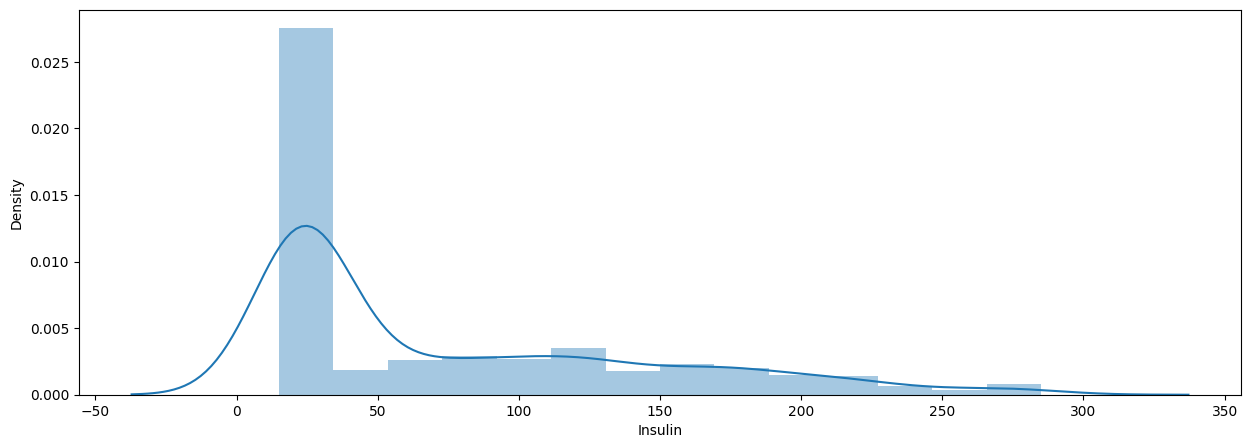

In [22]:
histograma(df['Insulin'])
print(df.shape)

### Construção do modelo com Logit
- Modelos Logísticos não costumam atingir R² alto como modelos lineares, lidam com probabilidades e variáveis discretas
- 0.2 a 0.4 pode ser considerado um bom ajuste

In [23]:
model = smf.logit('Outcome ~ Pregnancies + Glucose + BloodPressure + SkinThickness + Insulin + BMI + DiabetesPedigreeFunction + Age', data=df).fit()

print(model.summary())

Optimization terminated successfully.
         Current function value: 0.517438
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  938
Model:                          Logit   Df Residuals:                      929
Method:                           MLE   Df Model:                            8
Date:                Wed, 14 May 2025   Pseudo R-squ.:                  0.2531
Time:                        00:43:54   Log-Likelihood:                -485.36
converged:                       True   LL-Null:                       -649.86
Covariance Type:            nonrobust   LLR p-value:                 2.713e-66
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -9.0800      0.768    -11.830      0.000     -10.584

In [24]:
# Avaliação da significância da variável
# Quando aparecer com * terá significância igual na linguagem R
def format_significance(p_value):
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    elif p_value < 0.1:
        return '.'
    else:
        return ''

print("\nCoeficientes com Significância:")
for i, (coef, p_val) in enumerate(zip(model.params, model.pvalues)):
    significance = format_significance(p_val)
    print(f"{model.params.index[i]}: {coef:.4f} {significance}")


Coeficientes com Significância:
Intercept: -9.0800 ***
Pregnancies: 0.1409 ***
Glucose: 0.0385 ***
BloodPressure: -0.0095 
SkinThickness: 0.0037 
Insulin: -0.0014 
BMI: 0.1096 ***
DiabetesPedigreeFunction: 1.6200 ***
Age: 0.0044 


In [25]:
df_logit = df.copy()

df_logit['PregGroup'] = pd.cut(df_logit['Pregnancies'], 
                               bins=[-1, 0, 2, 5, 10, df['Pregnancies'].max()], 
                               labels=['0', '1-2', '3-5', '6-10', '11+'])

model = smf.logit('Outcome ~ C(PregGroup) + Glucose + BloodPressure + SkinThickness + Insulin + BMI + DiabetesPedigreeFunction + Age', data=df_logit).fit()

model.summary()

Optimization terminated successfully.
         Current function value: 0.513942
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Outcome   No. Observations:                  938
Model:                          Logit   Df Residuals:                      926
Method:                           MLE   Df Model:                           11
Date:                Wed, 14 May 2025   Pseudo R-squ.:                  0.2582
Time:                        00:43:54   Log-Likelihood:                -482.08
converged:                       True   LL-Null:                       -649.86
Covariance Type:            nonrobust   LLR p-value:                 2.723e-65
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -9.0459      0.821    -11.018      0.000     -10.655      -7.437
C(PregGroup)[T.1-2]         -0.1053      0.269     -0.391      0.696      -0.633       0.423
C(PregGroup)[T.3-5]          0.7484      0.269      2.786      0.005       0.222       1.275
C(PregGroup)[T.6-10]         1.0949      0.293      3.739      0.000       0.521       1.669
C(PregGroup)[T.11+]          0.9592      0.475      2.021      0.043       0.029       1.890
Glucose                      0.0376      0.004      9.942      0.000       0.030       0.045
BloodPressure               -0.0091      0.008     -1.144      0.253      -0.025       0.006
SkinThickness                0.0051      0.012      0.435      0.664      -0.018       0.028
Insulin                     -0.0011      0.001     -0.842      0.400      -0.004       0.001
BMI                          0.1096      0.018      6.180      0.000       0.075       0.144
DiabetesPedigreeFunction     1.6365      0.279      5.860      0.000       1.089       2.184
Age                          0.0052      0.009      0.605      0.545      -0.012       0.022
============================================================================================
"""

In [43]:
# import math
# math.exp(0.7484)

2.1136155249014883

In [27]:
def format_significance(p_value):
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    elif p_value < 0.1:
        return '.'
    else:
        return ''

print("\nCoeficientes com Significância:")
for i, (coef, p_val) in enumerate(zip(model.params, model.pvalues)):
    significance = format_significance(p_val)
    print(f"{model.params.index[i]}: {coef:.4f} {significance}")


Coeficientes com Significância:
Intercept: -9.0459 ***
C(PregGroup)[T.1-2]: -0.1053 
C(PregGroup)[T.3-5]: 0.7484 **
C(PregGroup)[T.6-10]: 1.0949 ***
C(PregGroup)[T.11+]: 0.9592 *
Glucose: 0.0376 ***
BloodPressure: -0.0091 
SkinThickness: 0.0051 
Insulin: -0.0011 
BMI: 0.1096 ***
DiabetesPedigreeFunction: 1.6365 ***
Age: 0.0052 


### Construção dos Modelos

In [28]:
X = df.drop(columns=['Outcome'])
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [29]:
model = DecisionTreeClassifier(random_state=42, min_samples_leaf=20)

model.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_leaf=20, random_state=42)

#### Classification Report
- macro avg: média das classes
- weighted avg: média ponderada das classes

In [30]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.81      0.83       108
           1       0.76      0.79      0.77        80

    accuracy                           0.80       188
   macro avg       0.80      0.80      0.80       188
weighted avg       0.80      0.80      0.80       188



In [31]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

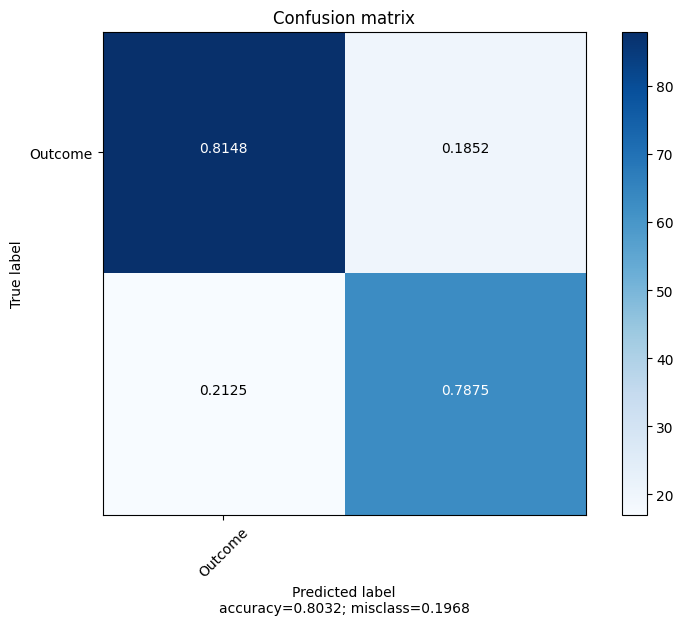

In [32]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), ['Outcome'])

### Validação cruzada para estimar a eficiência

In [33]:
cv_scores = cross_val_score(model, X, y, cv=5)

print(f'Scores de Validação Cruzada: {cv_scores}')
print(f'Média dos Scores: {cv_scores.mean():.4f}')
print(f'Desvio Padrão dos Scores: {cv_scores.std():.4f}')

Scores de Validação Cruzada: [0.65425532 0.67021277 0.74468085 0.78074866 0.71122995]
Média dos Scores: 0.7122
Desvio Padrão dos Scores: 0.0466


### Busca Hiperparamétrica

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Melhores hiperparâmetros: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Matriz de Confusão:


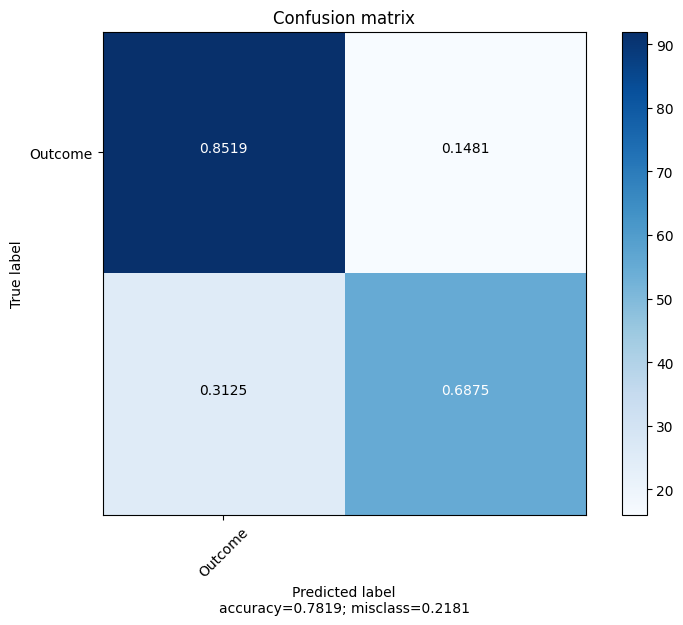

In [34]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Melhores hiperparâmetros: {best_params}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

print("Matriz de Confusão:")
plot_confusion_matrix(confusion_matrix(y_test, y_pred), ['Outcome'])

### Plot da Decision Tree

Acurácia: 80.32%


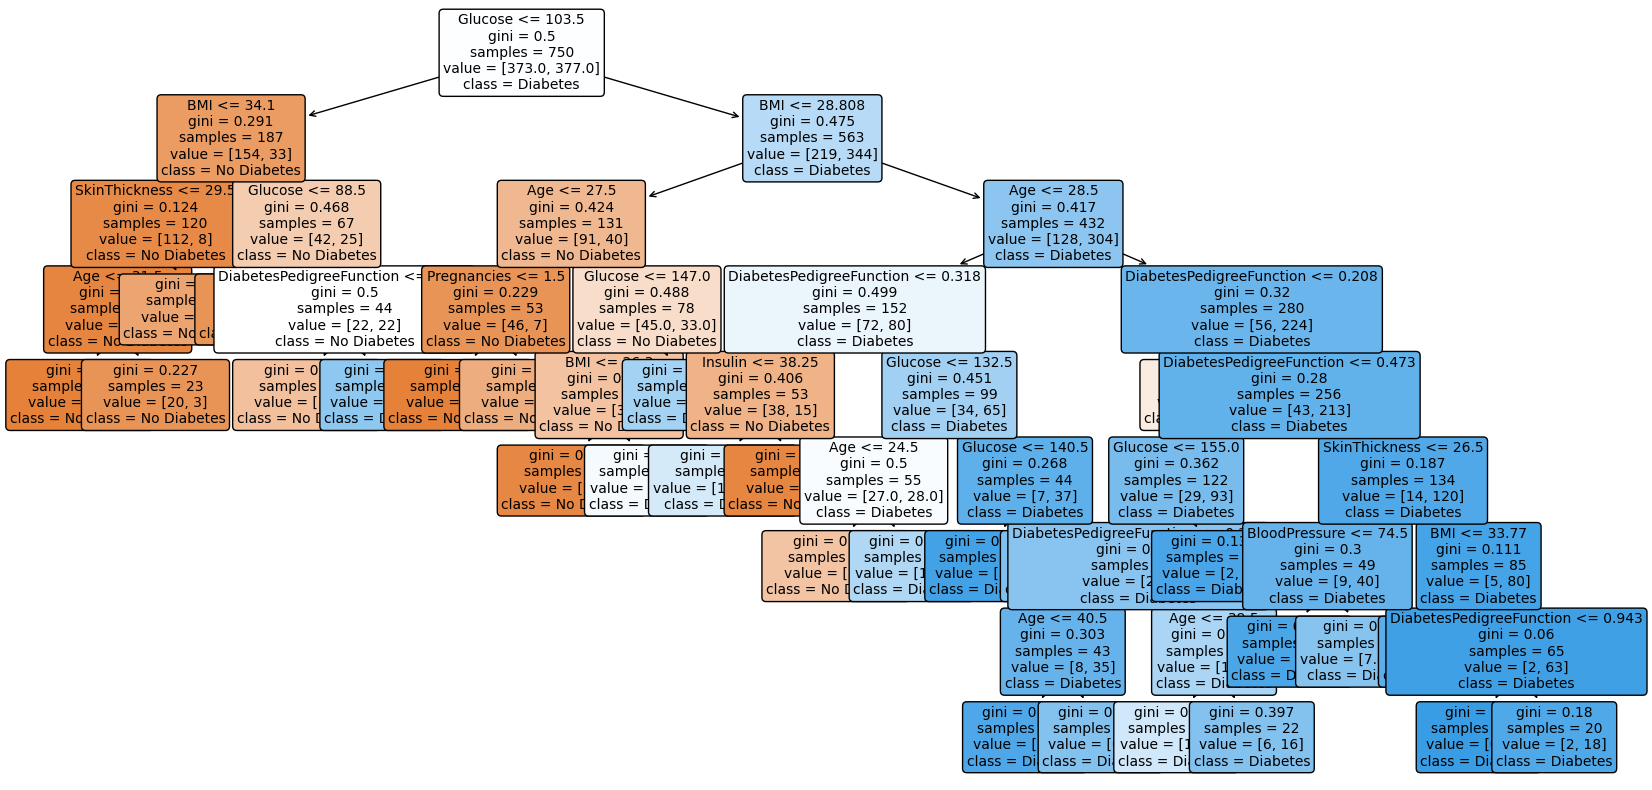

In [35]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(f'Acurácia: {round(accuracy_score(y_test, y_pred)*100, 2)}%')

plt.figure(figsize=(20, 10))
plot_tree(model, feature_names=X_train.columns, 
          class_names=['No Diabetes', 'Diabetes'], filled=True, rounded=True, fontsize=10)
plt.show()

### Tradeoff Precision-Recall e Curva ROC

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Melhores hiperparâmetros: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10}


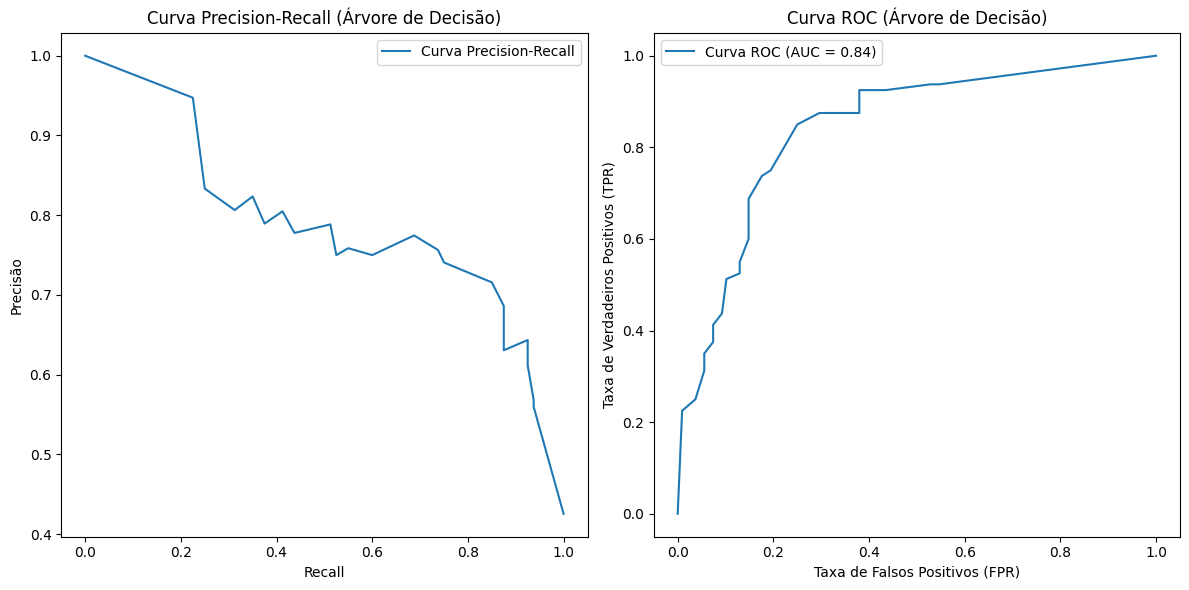

In [36]:
param_grid = {
    'min_samples_leaf': [10, 20, 50],
    'max_depth': [None, 5, 10],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Melhores hiperparâmetros: {best_params}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

y_scores = best_model.predict_proba(X_test)[:, 1]

precision, recall, thresholds_pr = precision_recall_curve(y_test, y_scores)
fpr, tpr, thresholds_roc = roc_curve(y_test, y_scores)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 6))

# Precision-Recall
plt.subplot(1, 2, 1)
plt.plot(recall, precision, label='Curva Precision-Recall')
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.title('Curva Precision-Recall (Árvore de Decisão)')
plt.legend()

# ROC
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC (Árvore de Decisão)')
plt.legend()

plt.tight_layout()
plt.show()

In [37]:
pr_data = {
    'Threshold': thresholds_pr,
    'Precision': precision[:-1],
    'Recall': recall[:-1]
}
pr_df = pd.DataFrame(pr_data)

print("Thresholds (Curva Precision-Recall):")
pr_df

Thresholds (Curva Precision-Recall):


,Threshold,Precision,Recall
0,0.000000,0.425532,1.0000
1,0.071429,0.559701,0.9375
2,0.083333,0.568182,0.9375
3,0.100000,0.611570,0.9250
4,0.181818,0.643478,0.9250
5,0.200000,0.630631,0.8750
6,0.272727,0.666667,0.8750
7,0.312500,0.686275,0.8750
8,0.400000,0.715789,0.8500
9,0.461538,0.740741,0.7500


### Random Forest

In [38]:
X = df.drop(columns=['Outcome'])
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

rf_model = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                               scoring='accuracy', cv=kf, verbose=1, n_jobs=-1)

grid_search_rf.fit(X_train, y_train)

best_rf_model = grid_search_rf.best_estimator_

y_pred_rf = best_rf_model.predict(X_test)

print(classification_report(y_test, y_pred_rf))
print(f'Acurácia: {round(accuracy_score(y_test, y_pred_rf)*100,2)}%')

Fitting 5 folds for each of 108 candidates, totalling 540 fits
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       108
           1       0.78      0.85      0.81        80

    accuracy                           0.84       188
   macro avg       0.83      0.84      0.83       188
weighted avg       0.84      0.84      0.84       188

Acurácia: 83.51%


Importância das características:
                    Feature  Importance
4                   Insulin    0.065588
0               Pregnancies    0.076775
3             SkinThickness    0.085098
2             BloodPressure    0.089734
7                       Age    0.133346
6  DiabetesPedigreeFunction    0.146757
5                       BMI    0.179976
1                   Glucose    0.222726


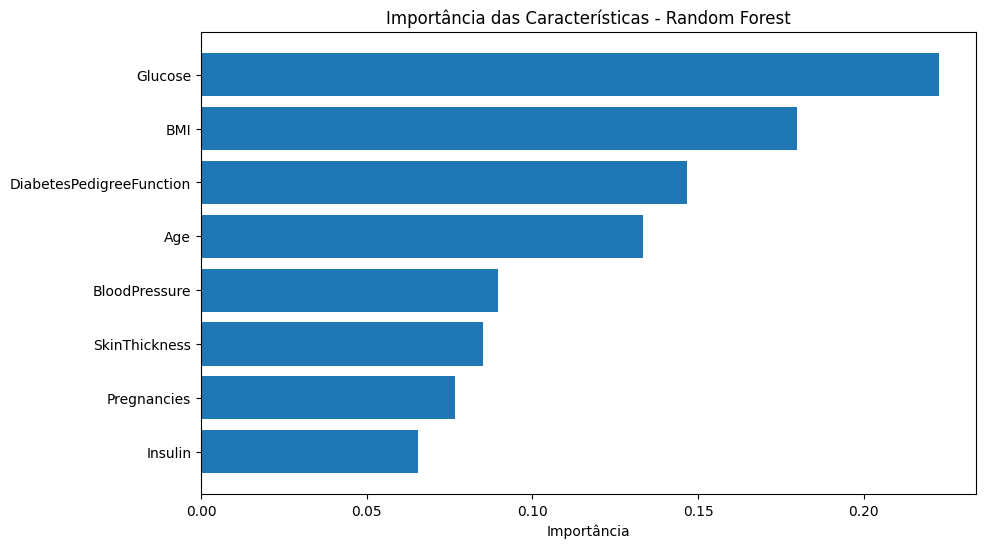

In [39]:
rf_model.fit(X_train, y_train)

importances = rf_model.feature_importances_

feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance')

print("Importância das características:")
print(feature_importances)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importância')
plt.title('Importância das Características - Random Forest')
plt.show()

### Comparativo de Modelos

Optimizing svc...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
svc Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86       108
           1       0.79      0.88      0.83        80

    accuracy                           0.85       188
   macro avg       0.84      0.85      0.84       188
weighted avg       0.85      0.85      0.85       188



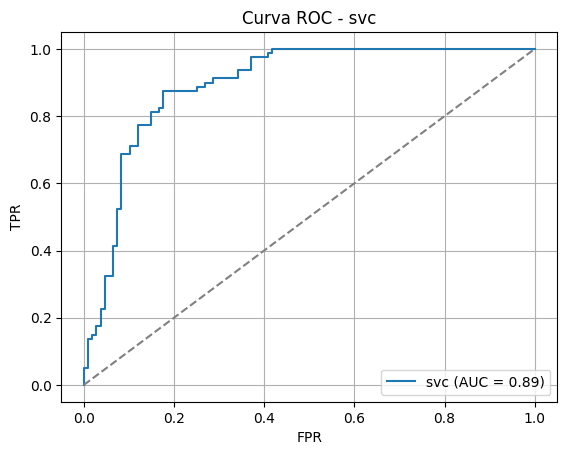

Optimizing xgb...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
xgb Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.81      0.82       108
           1       0.75      0.80      0.78        80

    accuracy                           0.80       188
   macro avg       0.80      0.80      0.80       188
weighted avg       0.81      0.80      0.80       188



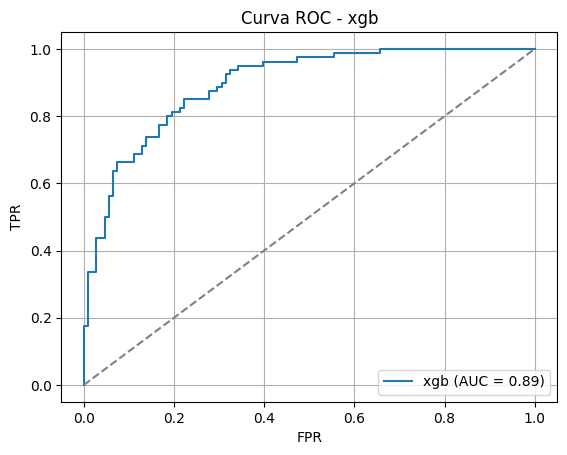

Optimizing lgbm...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Info] Number of positive: 377, number of negative: 373
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 843
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502667 -> initscore=0.010667
[LightGBM] [Info] Start training from score 0.010667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

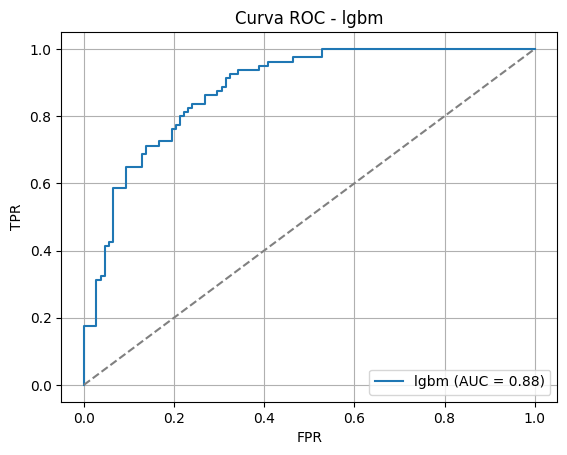

Optimizing nb...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
nb Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.78      0.79       108
           1       0.71      0.72      0.72        80

    accuracy                           0.76       188
   macro avg       0.75      0.75      0.75       188
weighted avg       0.76      0.76      0.76       188



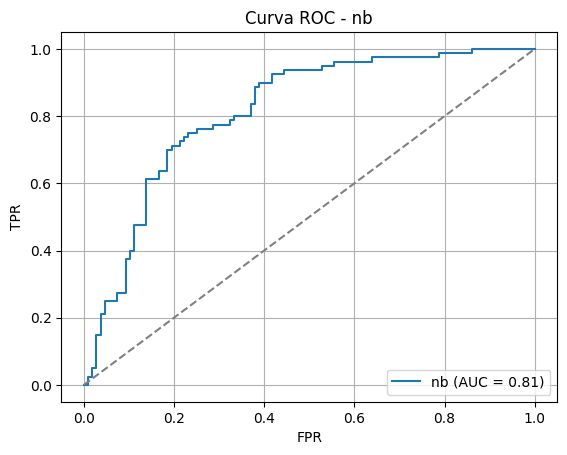

In [40]:
param_grids = {
    'svc': {
        'model__C': [0.1, 1, 10],
        'model__gamma': ['scale', 'auto'],
        'model__kernel': ['linear', 'rbf']
    },
    'xgb': {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [3, 5, 7],
        'model__learning_rate': [0.01, 0.1, 0.2]
    },
    'lgbm': {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 5, 10],
        'model__learning_rate': [0.01, 0.1, 0.2]
    },
    'nb': {
        'model__var_smoothing': [1e-9, 1e-8, 1e-7]
    }
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'svc': Pipeline([
        ('scaler', StandardScaler()),
        ('model', SVC(random_state=42))
    ]),
    'xgb': Pipeline([
        ('scaler', StandardScaler()),
        ('model', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
    ]),
    'lgbm': Pipeline([
        ('scaler', StandardScaler()),
        ('model', LGBMClassifier(random_state=42))
    ]),
    'nb': Pipeline([
        ('scaler', StandardScaler()),
        ('model', GaussianNB())
    ])
}


for name, model in models.items():
    print(f"Optimizing {name}...")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[name],
                               scoring='accuracy', cv=kf, verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    print(f"{name} Classification Report:")
    print(classification_report(y_test, y_pred))

    if hasattr(best_model.named_steps['model'], "predict_proba"):
        y_scores = best_model.predict_proba(X_test)[:, 1]
    elif hasattr(best_model.named_steps['model'], "decision_function"):
        y_scores = best_model.decision_function(X_test)
    else:
        continue

    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(f'Curva ROC - {name}')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

### Stacking com Regressão Logística

In [41]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

base_learners = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svc', SVC(probability=True, random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
]

penalties = ['l1', 'l2', 'elasticnet']
for penalty in penalties:
    if penalty == 'elasticnet':
        final_estimator = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, random_state=42)
    else:
        final_estimator = LogisticRegression(penalty=penalty, solver='saga' if penalty == 'l1' else 'lbfgs', random_state=42)
    
    stacking_model = StackingClassifier(estimators=base_learners, final_estimator=final_estimator)

    stacking_model.fit(X_train_scaled, y_train)

    accuracy = stacking_model.score(X_test_scaled, y_test)
    print(f"Acurácia do modelo de Stacking com penalização {penalty}: {accuracy:.2f}")

Acurácia do modelo de Stacking com penalização l1: 0.84
Acurácia do modelo de Stacking com penalização l2: 0.84
Acurácia do modelo de Stacking com penalização elasticnet: 0.85


### Redes Neurais

In [42]:
def network_model_1():
    model = Sequential()
    model.add(Dense(12, activation='relu', input_shape=(X_train_scaled.shape[1],)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def network_model_2():
    model = Sequential()
    model.add(Dense(12, activation='relu', input_shape=(X_train_scaled.shape[1],)))
    model.add(Dropout(0.25))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def network_model_3():
    model = Sequential()
    model.add(Dense(10, activation='relu', input_shape=(X_train_scaled.shape[1],)))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

kf = KFold(n_splits=5, shuffle=True, random_state=42)

meta_features = []
meta_targets = []

for train_idx, val_idx in kf.split(X_train_scaled):
    X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    m1 = network_model_1()
    m2 = network_model_2()
    m3 = network_model_3()

    m1.fit(X_tr, y_tr, epochs=100, batch_size=10, verbose=0)
    m2.fit(X_tr, y_tr, epochs=100, batch_size=10, verbose=0)
    m3.fit(X_tr, y_tr, epochs=100, batch_size=10, verbose=0)

    p1 = (m1.predict(X_val).flatten() > 0.5).astype(int)
    p2 = (m2.predict(X_val).flatten() > 0.5).astype(int)
    p3 = (m3.predict(X_val).flatten() > 0.5).astype(int)

    meta_features.extend(np.vstack([p1, p2, p3]).T)
    meta_targets.extend(y_val)

X_meta_train = pd.DataFrame(meta_features, columns=['model_1', 'model_2', 'model_3'])
y_meta_train = pd.Series(meta_targets)

final_model = LogisticRegression(penalty='l2', solver='lbfgs', random_state=42)
final_model.fit(X_meta_train, y_meta_train)

model_1 = network_model_1()
model_2 = network_model_2()
model_3 = network_model_3()

model_1.fit(X_train_scaled, y_train, epochs=100, batch_size=10, verbose=0)
model_2.fit(X_train_scaled, y_train, epochs=100, batch_size=10, verbose=0)
model_3.fit(X_train_scaled, y_train, epochs=100, batch_size=10, verbose=0)

p1_test = (model_1.predict(X_test_scaled).flatten() > 0.5).astype(int)
p2_test = (model_2.predict(X_test_scaled).flatten() > 0.5).astype(int)
p3_test = (model_3.predict(X_test_scaled).flatten() > 0.5).astype(int)

X_meta_test = pd.DataFrame({
    'model_1': p1_test,
    'model_2': p2_test,
    'model_3': p3_test
})

stacking_preds = final_model.predict(X_meta_test)
stacking_accuracy = accuracy_score(y_test, stacking_preds)
print(f"Acurácia do modelo de Stacking: {stacking_accuracy:.2f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000236211E8820> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
5/5 ━━━━